Import necessary libraries

In [ ]:
import os
import re
import shutil

## Data Loading and preparation

In [ ]:
# Initialize path to data folder
base_data_path = "path_to_folder_to_store_data"

# Create 2 new directories to store train images and their labels
imagesTr_path = os.path.join(base_data_path, "imagesTr")
labelsTr_path = os.path.join(base_data_path, "labelsTr")

os.makedirs(imagesTr_path, exist_ok=True)
os.makedirs(labelsTr_path, exist_ok=True)

Download IDEAS [Dataset](https://openneuro.org/datasets/ds005602/versions/1.0.0) from OpenNeuro 

In [ ]:
downloaded_data_folder = "path_to_the_downloaded_data"

Upon analysis, it is found that there are some masks missing in the data set. Also, there are no masks for healthy patients. We need to create them manually. Kindly read the information the [dataset](https://openneuro.org/datasets/ds005602/versions/1.0.0) page for more information, 

In [ ]:
missing_masks = [12, 115, 261, 269, 326, 331, 353, 368, 437, 122, 242]

def copy_and_rename_input_images(data_folder, imagesTr_path, missing_masks):
    """Function to read T1w from respective directory and rename to comply with nnUNet format

    Args:
        data_folder (str): Path to the downloaded original dataset folder
        imagesTr_path (str): Path to store renamed input images
        missing_masks (List): Python list contains ids of missing masks 
    """
    for root, dirs, files in os.walk(data_folder):
        print(dirs)
        for file in files:
            if file.endswith('T1w.nii') or file.endswith('T1w.nii.gz'):
                # Construct the full file path
                file_path = os.path.join(root, file)
                ids = re.findall(r'-(\d+)', file) # extract only id from the name
                if (len(ids[0]) < 4) and (int(ids[0]) not in missing_masks): # filter out healthy patients images 
                    shutil.copy(file_path, os.path.join(imagesTr_path, f"patient_{ids[0]}_0000.nii.gz"))
    print("Copying and renaming of input images done")               

copy_and_rename_input_images(downloaded_data_folder, imagesTr_path, missing_masks)

In [ ]:
downloaded_mask_folder = "Path_to_downloaded_masks"

def copy_and_rename_mask_files(mask_folder, labelsTr_path):
    """Function to read raw masks from respective directory and rename to comply with nnUNet format

    Args:
        mask_folder (str): Path to the downloaded original masks folder
        labelsTr_path (str): Path to store renamed input masks
    """
    for root, dirs, files in os.walk(mask_folder):
        for file in files:
            if file.endswith('MaskInRawData.nii') or file.endswith('MaskInRawData.nii.gz'):
                # Construct the full file path
                file_path = os.path.join(root, file)
                id = re.findall(r'(\d+)_', file) # extract only id from the name
                shutil.copy(file_path, os.path.join(labelsTr_path, f"patient_{id[0]}.nii.gz"))
    print("Copying and renaming of masks done")

copy_and_rename_mask_files(downloaded_mask_folder, labelsTr_path)

Create masks for the healthy patients. There are 100 healthy patient's MRI images but there are no labels avaialable. The healthy patients IDs have 4 digits and starts from 4001. Generate masks for these images using a python scripts found under epilepsydetection folder in the repo

In [ ]:
healthy_patients_mask = "path_to_newly_generated_mask" 

def copy_and_rename_healthy_mask_files(healthy_patients_mask, labelsTr_path):
    """Function to read newly created masks for healthy patients from respective directory and rename to comply with nnUNet format
    
    Args:
        healthy_patients_mask (str): Path to the newly created masks
        labelsTr_path (_type_): Path to store renamed input masks
    """
    for root, dirs, files in os.walk(healthy_patients_mask):
        for file in files:
            if file.endswith('MaskInOrig.nii') or file.endswith('MaskInOrig.nii.gz'):
                # Construct the full file path
                file_path = os.path.join(root, file)                       
                ids = re.findall(r'(\d+)_', file) # extract only id from the name
                if (len(ids[0]) == 4):           
                    shutil.copy(file_path, os.path.join(labelsTr_path, f"patient_{ids[0]}.nii.gz"))
    print("Copying and renaming of masks done")   

copy_and_rename_healthy_mask_files(healthy_patients_mask, labelsTr_path)

Visualizing some input data

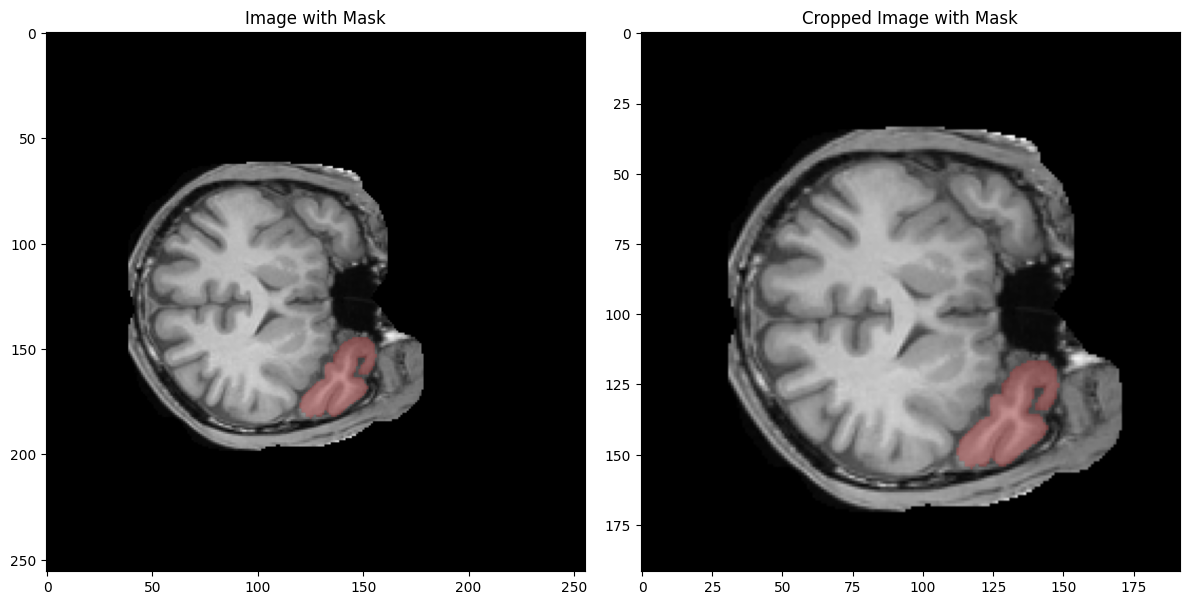

In [ ]:
# Some random image with mask before and after cropping. It is seen that the mask fits properly.

## Model Loading

* __Fully Automated & Adaptable__  <p style="font-size:14px; font-family:Arial;"> nnU-Net auto-configures preprocessing, architecture, and training for any medical image segmentation task. Robust again different dimensions </p>
* __State-of-the-Art Performance__  <p style="font-size:14px; font-family:Arial;"> Outperforms most models in segmentation benchmarks (BraTS, MSD, KiTS) without manual tuning. </p>
* __Plug & Play Simplicity__  <p style="font-size:14px; font-family:Arial;"> Just organize your dataset, train, and get top-tier results with multi-GPU support.</p>


Follow the steps in the official [documentation](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/installation_instructions.md) to setup the model



In [ ]:
# Create a virutal python environment 
python -m venv venv

 <p style="font-size:14px; font-family:Arial;"> Install <a href=https://pytorch.org/get-started/locally// > PyTorch </a> as described on their website (conda/pip). Please install the latest version with support for your hardware (cuda, mps, cpu). <br>
 DO NOT JUST pip install nnunetv2 WITHOUT PROPERLY INSTALLING PYTORCH FIRST. </p>

In [ ]:
# To install as integrative framework 
git clone https://github.com/MIC-DKFZ/nnUNet.git
cd nnUNet
pip install -e .

<p style="font-size:14px; font-family:Arial;"> nnUNet requires specific folder structure as shown <a href="https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/setting_up_paths.md">here</a>. Create them first. </p>

In [ ]:
mkdir nnUNetraw
mkdir nnUNetpreprocessed
mkdir nnUNetresults

cd nnUNetraw
mkdir Dataset001_BrainEpilepsy # each dataset names DatasetXXX_YYY where XXX is a 3-digit identifier (such as 001, 002, 043, 999, ...) and YYY is the (unique) dataset name.

# Move the train and label data into the dataset folder
mv imagesTr Dataset001_BrainEpilepsy/
mv labelsTr Dataset001_BrainEpilepsy/


<p style="font-size:14px; font-family:Arial;">Setup the environment variables properly. For reference, check the documentation <a href=https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/set_environment_variables.md>here.</a><br>
You can permanently set paths by locating the .bashrc file in your home folder, open it and add the following lines to the bottom of the file</p>

In [ ]:
export nnUNet_raw="/media/fabian/nnUNet_raw"
export nnUNet_preprocessed="/media/fabian/nnUNet_preprocessed"
export nnUNet_results="/media/fabian/nnUNet_results"

<p style="font-size:14px; font-family:Arial;">Once the paths are set correctly, we need to preprocess the dataset to check whether it is suitable to train it with nnUNet model.<br> The easiest way to run fingerprint extraction, experiment planning and preprocessing is by running the below command in the terminal <br><br> <em>nnUNetv2_plan_and_preprocess -d DATASET_ID --verify_dataset_integrity </em> <br><br>Where DATASET_ID is the dataset id of your dataset. For example, 001 in our case, so <br> <br><em> nnUNetv2_plan_and_preprocess -d DATASET_ID --verify_dataset_integrity</em> </p>

## Model Training

<p style="font-size:14px; font-family:Arial;">Training models is done with the nnUNetv2_train command. The general structure of the command is:</p>

In [ ]:
nnUNetv2_train DATASET_NAME_OR_ID UNET_CONFIGURATION FOLD [additional options, see -h]

* DATASET_NAME_OR_ID <p style="font-size:14px; font-family:Arial;"> Id used in our previous step.</p> 
* UNET_CONFIGURATION <p style="font-size:14px; font-family:Arial;"> String that identifies the requested U-Net configuration such as 2d, 3d_fullres, 3d_lowres, 3d_cascade_lowres. </p>
* FOLD <p style="font-size:14px; font-family:Arial;"> Specifies which fold of the 5-fold-cross-validation is trained.  <br><br>
Additional details about model training are available <a href="https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/how_to_use_nnunet.md#model-training"> here </a> </p>

In [ ]:
# example command for training

nnUNetv2_train 001 3d_fullres 2 

<p style="font-size:12px; font-family:Arial;">The trained models will be written to the nnUNet_results folder. Each training obtains an automatically generated output folder name:

nnUNet_results/DatasetXXX_MYNAME/TRAINER_CLASS_NAME__PLANS_NAME__CONFIGURATION/FOLD</p>

![Training metrics](training_metrics_plot.png)